<a href="https://colab.research.google.com/github/Kabongosalomon/AMMI-NLP/blob/master/word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pretrained Word Embeddings

It turns out that are a ton of pretrained neural networks for accomplishing specific tasks. In this notebook, we'll explore what embeddings are and some of the cool things we can do with them once we have them.

---

## Representing Inputs
### One-Hot Representation
Traditionally, inputs to a neural network can be represented using a **One-Hot Representation**, where we assemble a vector of N values where each value represents a given class.

For example, if we're classifying animals with our neural network, our one-hot representation may look like: < Bird, Cat, Dog, Fish > and <1,0,0,0> would represent a Bird. There are some problems with this. As the number of classes grows large, we waste a lot of space storing zeros that only tell us what we *don't* care about. Additionally, this gives us no way to represent the fact that Cats are more similar to Dogs than to Fish. 

In the Char-RNN notebook, we build a vocabulary of characters appearing in the training data and assign an ID to each one, letting Tensorflow handle the internal representation of the inputs. Because of this, our network learns only about what character should appear next based on the previous characters.

### Embedding Representation
An **embedding** is a representation of a value in a complex dataset in relation to the entire range of possible inputs based on some combination of features learned by the network. These can be a bit more abstract, which allows us to represent inputs as the neural network would rather than using firm classifications. Rather than a vector of on/off flags, we'll use a vector of floating point values, where each element represents the strength of a feature present in the input. One way we can generate an embedding vector is to select a layer in our neural network before the output layer and look at the values produced by it.

---
## Further Reading
If you're interested in learning more about how word embeddings can be trained, there's a great tutorial about [Word2Vec](https://www.tensorflow.org/tutorials/word2vec) on tensorflow.org or [this series of blog posts by Memo Akten](https://medium.com/artists-and-machine-intelligence/ami-residency-part-1-exploring-word-space-andprojecting-meaning-onto-noise-98af7252f749)

Embedding vectors have all sorts of applications across various types of data. 
* [Here's](https://artsexperiments.withgoogle.com/tsnemap/) one example where works of art have been mapped by their similarity, which lets us [morph from one work to another](https://artsexperiments.withgoogle.com/xdegrees).

## Using pip to install gensim
[Gensim](https://radimrehurek.com/gensim/) is a Python library that makes it very easy to work with word embeddings. This cell may take a few moments to run as it is installed.

In [1]:
!pip install -q gensim==3.2.0

     |████████████████████████████████| 15.9MB 201kB/s 


## Downloading our pre-trained word embeddings
We're going to download a set of three million pretrained English word embeddings from a Word2Vec model that was trained on Google News. Some information from the project can be found on [this page](https://code.google.com/archive/p/word2vec/) along with the link to the Google Drive link. The next few cells will take care of this process for you.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '0B7XkCwpI5KDYNlNUTTlSS21pQmM'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

In [0]:
!gunzip GoogleNews-vectors-negative300.bin.gz

## Loading the embeddings into Gensim
The next cell will load word embeddings for the two hundred thousand most common words in English. 

The dataset will not contain excessively common "stop words" such as 'and', and others. These sorts of words don't really add to the meaning of the other words in a text and so are often omitted while training word embeddings.

While the dataset contains nearly three million words, we're going to cut it down to size so you don't have to wait as long.

In [4]:
from gensim.models.keyedvectors import KeyedVectors
gensim_model = KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin', binary=True, limit=300000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Here's an example of how a word is represented in our embedding space:

In [5]:
print('hello =', gensim_model['hello'])

hello = [-0.05419922  0.01708984 -0.00527954  0.33203125 -0.25       -0.01397705
 -0.15039062 -0.265625    0.01647949  0.3828125  -0.03295898 -0.09716797
 -0.16308594 -0.04443359  0.00946045  0.18457031  0.03637695  0.16601562
  0.36328125 -0.25585938  0.375       0.171875    0.21386719 -0.19921875
  0.13085938 -0.07275391 -0.02819824  0.11621094  0.15332031  0.09082031
  0.06787109 -0.0300293  -0.16894531 -0.20800781 -0.03710938 -0.22753906
  0.26367188  0.012146    0.18359375  0.31054688 -0.10791016 -0.19140625
  0.21582031  0.13183594 -0.03515625  0.18554688 -0.30859375  0.04785156
 -0.10986328  0.14355469 -0.43554688 -0.0378418   0.10839844  0.140625
 -0.10595703  0.26171875 -0.17089844  0.39453125  0.12597656 -0.27734375
 -0.28125     0.14746094 -0.20996094  0.02355957  0.18457031  0.00445557
 -0.27929688 -0.03637695 -0.29296875  0.19628906  0.20703125  0.2890625
 -0.20507812  0.06787109 -0.43164062 -0.10986328 -0.2578125  -0.02331543
  0.11328125  0.23144531 -0.04418945  0.108398

Whoops, that's really dense. Visualizing our embeddings can help us draw conclusions about our dataset and gain some insight into what our neural network is learning.

T-SNE is an algorithm that reduces the dimensionality of our embedding vectors. The Google News Word2Vec embeddings are originally 300-dimensional, but T-Sne will let us view them collapsed into a 2D space based on their similarities.

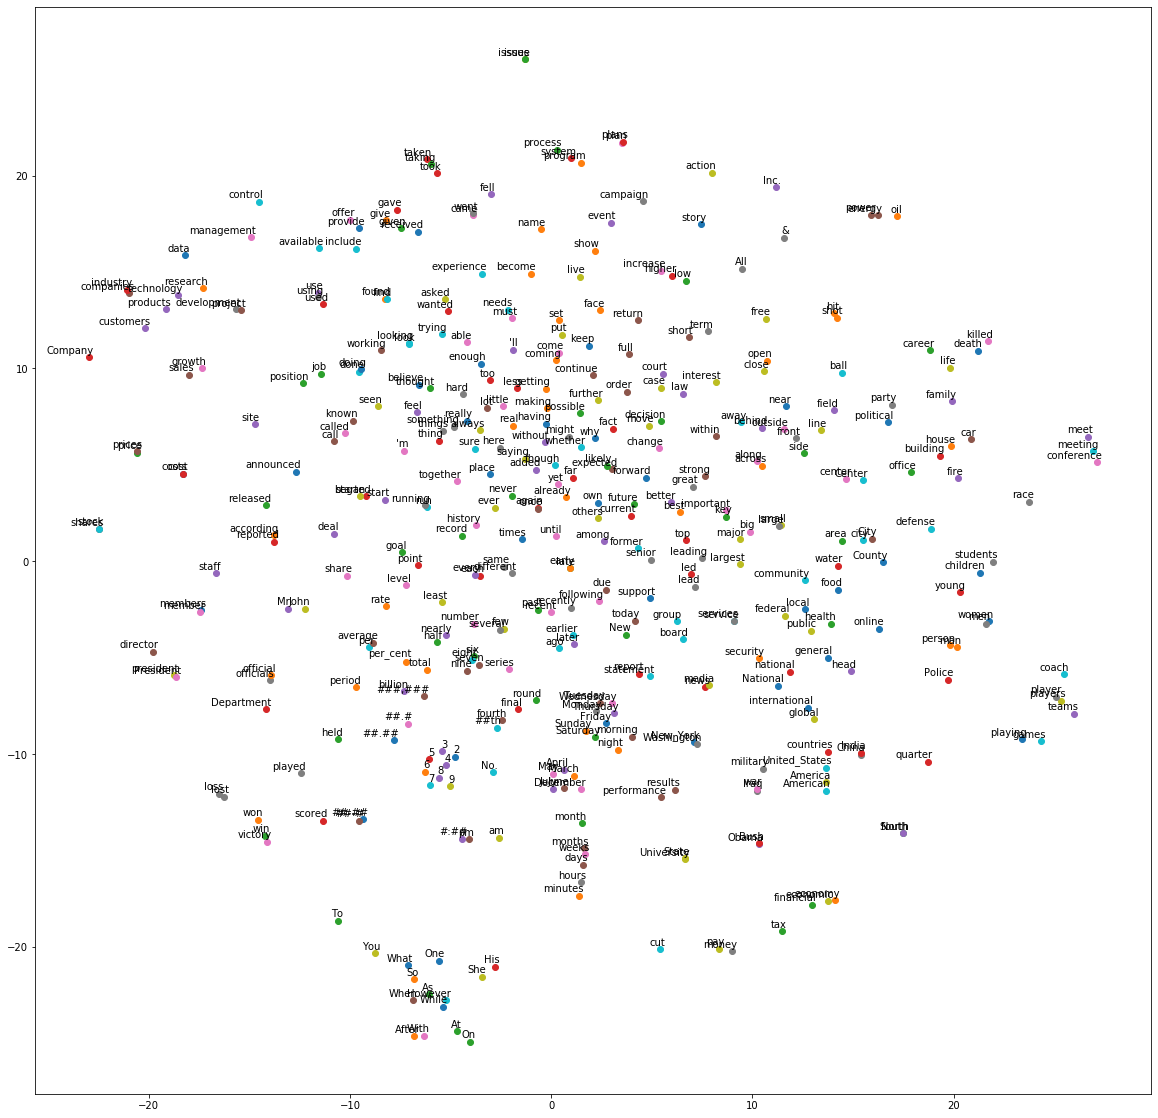

In [6]:
from sklearn.manifold import TSNE
from matplotlib import pylab

words = [word for word in gensim_model.index2word[200:600]]
embeddings = [gensim_model[word] for word in words]
words_embedded = TSNE(n_components=2).fit_transform(embeddings)

pylab.figure(figsize=(20, 20))
for i, label in enumerate(words):
  x, y = words_embedded[i, :]
  pylab.scatter(x, y)
  pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom')
pylab.show()

Note that from looking at the graph above we can see that words with similar usages appear near each other. For example,
* Words dealing with time are next to each other (minutes, hours, months, weeks, days)
* Countries appear near each other (India, China, United_States)
* US Presidents (Bush, Obama)
* Words associated with games or sports (playing, played, player, coach, gamers, players, teams)
* Numbers (2, 3, 4, 5, 6, 7, 8, 9)
* Directions (North, South)
* Words related to probability (whether, might, expected, never, sure, possible)

Can you find any other interesting ones? Try changing the [200:600] in the cell above to try another range of values.


## Interesting applications of word embeddings

Now that we have some idea of what knowledge our neural network has, let's explore some of the more interesting implications.

### Finding similar words:

In [7]:
gensim_model.most_similar(positive=['January'])

[('February', 0.9675938487052917),
 ('October', 0.9492781162261963),
 ('December', 0.940860390663147),
 ('November', 0.9326643943786621),
 ('August', 0.9252052307128906),
 ('September', 0.9134546518325806),
 ('March', 0.8933349847793579),
 ('April', 0.8740777373313904),
 ('June', 0.8731662034988403),
 ('July', 0.8625510931015015)]

### Combining Words:
Since our words are represented as an array of floats, we can add some together and lookup what their combination is.

```
nature + science = biology, ecology
```



In [8]:
gensim_model.most_similar(positive=['nature', 'science'])

[('biology', 0.5784977674484253),
 ('ecology', 0.5561811923980713),
 ('scientific', 0.5484973788261414),
 ('sciences', 0.5216706395149231),
 ('botany', 0.5139989852905273),
 ('physics', 0.4938763678073883),
 ('geography', 0.4893343150615692),
 ('geology', 0.4885980486869812),
 ('mathematics', 0.4871952533721924),
 ('quantum_physics', 0.4866980314254761)]

### Finding analogous words:

We can do math with the embedding vectors for words to find analogies between words.

king - man + woman = queen

Paris - France + Germany = Berlin

Tea - England + United_States = Coffee

North - South + West = East

In [9]:
gensim_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454),
 ('royal_palace', 0.5087165832519531)]

In [17]:
gensim_model.most_similar(
    positive=['Paris', 'Congo'], 
    negative=['France'])

[('Kinshasa', 0.6279705762863159),
 ('eastern_Congo', 0.5826098322868347),
 ('Kisangani', 0.5646954774856567),
 ('Ituri', 0.5612216591835022),
 ('eastern_DRC', 0.5590648651123047),
 ('Congo_DRC', 0.5588899254798889),
 ('DRC', 0.5496670007705688),
 ('DR_Congo', 0.5434396266937256),
 ('Congolese', 0.5388587117195129),
 ('Addis_Ababa', 0.5152034759521484)]

In [10]:
gensim_model.most_similar(
    positive=['Paris', 'Spain'], 
    negative=['France'])

[('Madrid', 0.7571903467178345),
 ('Barcelona', 0.6230698823928833),
 ('Seville', 0.5604877471923828),
 ('Buenos_Aires', 0.5557721853256226),
 ('Bilbao', 0.5505114793777466),
 ('Marrakesh', 0.5379421710968018),
 ('Valencia', 0.5292879343032837),
 ('Malaga', 0.5286389589309692),
 ('Málaga', 0.5119467973709106),
 ('Majorca', 0.5093432664871216)]

In [11]:
gensim_model.most_similar(positive=['Tea', 'United_States'], negative=['England'])

[('Coffee', 0.40512222051620483),
 ('Unites_States', 0.36414289474487305),
 ('tea', 0.3635876178741455),
 ('coffee', 0.3620995879173279),
 ('Teas', 0.3539789915084839),
 ('U.S.', 0.35077792406082153),
 ('Specialty_Coffee', 0.34735968708992004),
 ('teas', 0.3444087505340576),
 ('specialty_coffees', 0.3330366313457489),
 ('Untied_States', 0.3264850974082947)]

In [12]:
gensim_model.most_similar(positive=['North', 'West'], negative=['South'])

[('East', 0.6172998547554016),
 ('Central', 0.4374283254146576),
 ('Hebron', 0.3680270314216614),
 ('Western', 0.36749526858329773),
 ('Northeast', 0.36656689643859863),
 ('NORTH', 0.3646947145462036),
 ('Northwest', 0.353318989276886),
 ('east', 0.3532946705818176),
 ('WEST', 0.349323570728302),
 ('FWL', 0.34146690368652344)]

We can put these together to programmatically modify sentences and phrases word by word, with varying results:

In [0]:
def shift_context(sentence, from_context, to_context):
  new_sentence = []
  for word in sentence.split():
    if word in gensim_model:
      word = gensim_model.most_similar(
          positive=[word, to_context], negative=[from_context])[0][0]
    new_sentence.append(word)

  return ' '.join(new_sentence)

In [14]:
sentence = 'restaurant serving coffee with cream and bread'
print(shift_context(sentence, 'regular', 'fancy'))

steakhouse served cappuccino snazzy frou_frou and baguettes


Unfortunately, the results are not always perfect with this approach, for example:

excellent - positive + negative = 

```
[(u'terrific', 0.5454081296920776),
 (u'superb', 0.5449916124343872),
 (u'exceptional', 0.5175209641456604),
 (u'Excellent', 0.4948967695236206),
 (u'impeccable', 0.49398699402809143),
 (u'superlative', 0.4694099426269531),
 (u'ideal', 0.4649601876735687),
 (u'fantastic', 0.46219557523727417),
 (u'abysmal', 0.4582980275154114),
 (u'atrocious', 0.45645347237586975)]
```
 The first eight results have roughly the same meaning as excellent. An unfortunate fact is that words can have many meanings across different contexts. Using these word embeddings, 
 
 ```plus - positive + negative = minus```. So the words positive and negative have become associated with mathematical sign rather than good and bad.




### Other Problems and Strategies

We run into an issue when attempting the following:


```
Austin - Texas + Oregon
```
Which yields "Corvallis" when we should expect "Salem". One way around this is to determine what relationship we want to target, in this case the full list of US States and their Capitals, and compute the average vector between our embeddings for this relationship. Gensim will let us do this by adding more parameters to the positive and negative lists.


In [15]:
gensim_model.most_similar(
    positive=['Austin', 'Oregon'],
    negative=['Texas']
)

[('Corvallis', 0.6858817338943481),
 ('Portland', 0.6762722730636597),
 ('Lake_Oswego', 0.6627551317214966),
 ('Beaverton', 0.6624646186828613),
 ('Tualatin', 0.6581562757492065),
 ('Tigard', 0.6536808013916016),
 ('Grants_Pass', 0.6237823963165283),
 ('Roseburg', 0.6129685640335083),
 ('Boise', 0.6093173623085022),
 ('Gresham', 0.6045904159545898)]

In [16]:
gensim_model.most_similar(
    positive=[
        'Austin', 'Atlanta', 'Nashville', 'Sacramento', 'Boston', 'Oregon'
    ],
    negative=[
        'Texas', 'Georgia', 'Tennessee', 'California', 'Massachusetts',
    ])

[('Portland', 0.5296077132225037),
 ('Seattle', 0.5245920419692993),
 ('Minneapolis', 0.4854247570037842),
 ('Milwaukee', 0.47816258668899536),
 ('Denver', 0.4711327850818634),
 ('Portland_Ore.', 0.4687800705432892),
 ('Chicago', 0.4681437313556671),
 ('Toronto', 0.4467437267303467),
 ('Vancouver', 0.4452194273471832),
 ('Beaverton', 0.4420887231826782)]

While still not the answer we were looking for, we can now see that our model has learned about the relationship between major cities and their US states in general rather than state capitals. One explanation for this could be that more populous cities are more likely to be featured in news articles when a state is mentioned.